#### --- **Installation des bibliothèques nécessaires** ---

In [1]:
!pip install lightgbm catboost xgboost graphviz missingno

In [2]:
import sys
!{sys.executable} -m pip install imbalanced-learn

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (roc_auc_score, average_precision_score, classification_report,
                             confusion_matrix, precision_recall_curve, roc_curve,
                             precision_score, recall_score, f1_score, accuracy_score)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)

### >>> **Chargement des données** <<<

In [4]:
POS_CASH_BALANCE = pd.read_csv(r"C:\Users\mrkha\Desktop\Cours 5ème année\Mémoire\bases de données\POS_CASH_balance.csv")
PREVIOUS_APPLICATION = pd.read_csv(r"C:\Users\mrkha\Desktop\Cours 5ème année\Mémoire\bases de données\previous_application.csv")
CREDIT_CARD_BALANCE = pd.read_csv(r"C:\Users\mrkha\Desktop\Cours 5ème année\Mémoire\bases de données\credit_card_balance.csv")
BUREAU = pd.read_csv(r"C:\Users\mrkha\Desktop\Cours 5ème année\Mémoire\bases de données\bureau.csv")
INSTALLEMENTS_PAYMENTS = pd.read_csv(r"C:\Users\mrkha\Desktop\Cours 5ème année\Mémoire\bases de données\installments_payments.csv")
APPLICATION_TRAIN = pd.read_csv(r"C:\Users\mrkha\Desktop\Cours 5ème année\Mémoire\bases de données\application_train.csv")

### >>> **Analyse exploratoire des données** <<<

In [5]:
for name, df in {
    "APPLICATION_TRAIN": APPLICATION_TRAIN,
    "BUREAU": BUREAU,
    "PREVIOUS_APPLICATION": PREVIOUS_APPLICATION,
    "POS_CASH_BALANCE": POS_CASH_BALANCE,
    "CREDIT_CARD_BALANCE": CREDIT_CARD_BALANCE,
    "INSTALLEMENTS_PAYMENTS": INSTALLEMENTS_PAYMENTS
}.items():
    print(f"--- {name} ---")
    print(df.shape)          # Nb de lignes et colonnes
    print(df.columns[:10])   # Un aperçu des colonnes
    print(df.isna().mean().sort_values(ascending=False).head(10))  # Taux de NaN
    print(df.dtypes.value_counts()) # Types de variables
    print("\n")

--- APPLICATION_TRAIN ---
(307511, 122)
Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY'],
      dtype='object')
COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
dtype: float64
float64    65
int64      41
object     16
Name: count, dtype: int64


--- BUREAU ---
(1716428, 17)
Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG'],
      dtype='object')
AMT_ANNUITY               0.7147

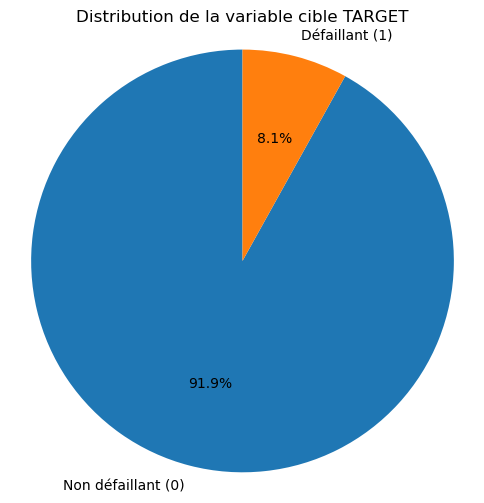

In [6]:
# Compter les occurrences de chaque classe de TARGET
target_counts = APPLICATION_TRAIN['TARGET'].value_counts()

# Étiquettes pour le diagramme
labels = ['Non défaillant (0)', 'Défaillant (1)']

# Tracer le diagramme
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution de la variable cible TARGET')
plt.axis('equal')  # Pour un cercle parfait
plt.show()

In [7]:
APPLICATION_TRAIN.describe()
APPLICATION_TRAIN.select_dtypes("object").nunique().sort_values(ascending=False)

ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
CODE_GENDER                    3
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
dtype: int64

<Axes: xlabel='TARGET', ylabel='AMT_INCOME_TOTAL'>

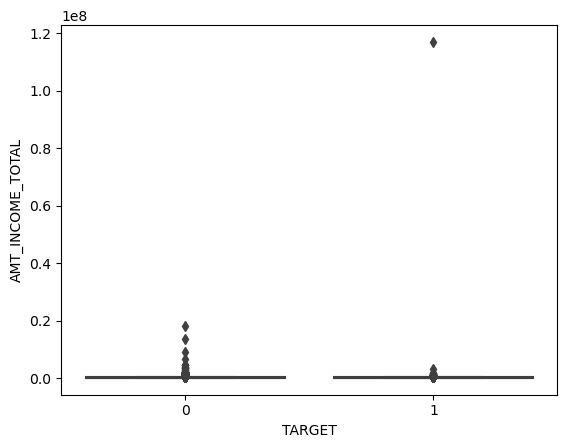

In [8]:
# Comparaison revenu par cible
sns.boxplot(x="TARGET", y="AMT_INCOME_TOTAL", data=APPLICATION_TRAIN)

### >>>**AGREGATION DES DONNEES DES TABLES SECONDAIRES**<<<

In [9]:
#Agrégation de POS_CASH_BALANCE
def final_status(series):
    # si toutes les lignes sont 'Active' -> 'Active', sinon 'Completed'
    return "Active" if (series == "Active").all() else "Completed"

pos_cash_agg = (
    POS_CASH_BALANCE.groupby("SK_ID_PREV")
      .apply(lambda g: pd.Series({
          # SK_ID_CURR (s'il y a plusieurs valeurs par erreur, on prend la plus fréquente)
          "SK_ID_CURR": g["SK_ID_CURR"].mode().iat[0] if not g["SK_ID_CURR"].mode().empty else g["SK_ID_CURR"].iloc[0],

          # Statut final selon ta règle
          "FINAL_CONTRACT_STATUS": final_status(g["NAME_CONTRACT_STATUS"]),

          # Nombre d'échéances prévues (CNT_INSTALMENT est répété par ligne -> on prend le max/first non-null)
          "NB_ECHEANCES": g["CNT_INSTALMENT"].dropna().max() if g["CNT_INSTALMENT"].notna().any() else np.nan,

          # Nombre de mois/enregistrements avec retard (SK_DPD > 0)
          "NB_RETARDS": (g["SK_DPD"].fillna(0) > 0).sum(),

          # Nombre de mois/enregistrements en défaut (SK_DPD_DEF > 0)
          "NB_DEFAUTS": (g["SK_DPD_DEF"].fillna(0) > 0).sum(),
      }))
      .reset_index()
)

# Ratios (sécurisés contre division par zéro)
pos_cash_agg["RATIO_RETARD_PAR_ECHEANCE"] = np.where(pos_cash_agg["NB_ECHEANCES"].fillna(0) > 0,
                                            pos_cash_agg["NB_RETARDS"] / pos_cash_agg["NB_ECHEANCES"],
                                            np.nan)
pos_cash_agg["RATIO_DEFAUT_PAR_ECHEANCE"] = np.where(pos_cash_agg["NB_ECHEANCES"].fillna(0) > 0,
                                            pos_cash_agg["NB_DEFAUTS"] / pos_cash_agg["NB_ECHEANCES"],
                                            np.nan)

# Résultat final
POS_CASH_BALANCE_AGG = pos_cash_agg[[
    "SK_ID_PREV",
    "SK_ID_CURR",
    "FINAL_CONTRACT_STATUS",
    "NB_ECHEANCES",
    "NB_RETARDS",
    "NB_DEFAUTS",
    "RATIO_RETARD_PAR_ECHEANCE",
    "RATIO_DEFAUT_PAR_ECHEANCE",
]]
print(POS_CASH_BALANCE_AGG.head())

   SK_ID_PREV  SK_ID_CURR FINAL_CONTRACT_STATUS  NB_ECHEANCES  NB_RETARDS  \
0     1000001      158271             Completed          12.0           0   
1     1000002      101962             Completed           6.0           0   
2     1000003      252457                Active          12.0           0   
3     1000004      260094             Completed          10.0           0   
4     1000005      176456             Completed          10.0           0   

   NB_DEFAUTS  RATIO_RETARD_PAR_ECHEANCE  RATIO_DEFAUT_PAR_ECHEANCE  
0           0                        0.0                        0.0  
1           0                        0.0                        0.0  
2           0                        0.0                        0.0  
3           0                        0.0                        0.0  
4           0                        0.0                        0.0  


In [10]:
#Agrégation de CREDIT_CARD_BALANCE
def agreger_card_balance(card_balance: pd.DataFrame) -> pd.DataFrame:
    keys = ["SK_ID_PREV", "SK_ID_CURR"]

    # Détecter la colonne de statut
    if "STATUS" in CREDIT_CARD_BALANCE.columns:
        status_col = "STATUS"
    elif "NAME_CONTRACT_STATUS" in CREDIT_CARD_BALANCE.columns:
        status_col = "NAME_CONTRACT_STATUS"
    else:
        raise KeyError("Colonne de statut introuvable (STATUS ou NAME_CONTRACT_STATUS).")

    # 1) ligne la plus récente = MONTHS_BALANCE le plus petit
    idx = CREDIT_CARD_BALANCE.groupby(keys, dropna=False)["MONTHS_BALANCE"].idxmin()
    last_rows_raw = CREDIT_CARD_BALANCE.loc[idx, keys + ["AMT_BALANCE", "AMT_INST_MIN_REGULARITY", status_col]]

    # statut “dernier” (si pas Active => Completed)
    last_rows = (
        last_rows_raw
        .assign(
            last_AMT_BALANCE = last_rows_raw["AMT_BALANCE"],
            last_AMT_INST_MIN_REGULARITY = last_rows_raw["AMT_INST_MIN_REGULARITY"],
            last_status_recent = np.where(last_rows_raw[status_col].eq("Active"), "Active", "Completed")
        )[keys + ["last_AMT_BALANCE", "last_AMT_INST_MIN_REGULARITY", "last_status_recent"]]
        .reset_index(drop=True)
    )

    # 2) Compteurs et ratios parmi les statuts Active
    df2 = CREDIT_CARD_BALANCE.assign(
        is_active = CREDIT_CARD_BALANCE[status_col].eq("Active").astype(int),
        has_delay = (CREDIT_CARD_BALANCE[status_col].eq("Active") & CREDIT_CARD_BALANCE["SK_DPD"].ne(0)).astype(int),
        has_default = (CREDIT_CARD_BALANCE[status_col].eq("Active") & CREDIT_CARD_BALANCE["SK_DPD_DEF"].ne(0)).astype(int),
    )

    agg_counts = (
        df2.groupby(keys, dropna=False)[["is_active", "has_delay", "has_default"]]
           .sum()
           .rename(columns={
               "is_active": "nb_active",
               "has_delay": "nb_retard",
               "has_default": "nb_defaut",
           })
           .reset_index()
    )

    # 3) Ratios (protège division par zéro)
    agg_counts["ratio_retard_sur_active"] = (
        agg_counts["nb_retard"] / agg_counts["nb_active"].replace(0, pd.NA)
    ).fillna(0)

    agg_counts["ratio_defaut_sur_active"] = (
        agg_counts["nb_defaut"] / agg_counts["nb_active"].replace(0, pd.NA)
    ).fillna(0)

    # 4) Merge final
    CREDIT_CARD_BALANCE_AGG = (
        last_rows.merge(agg_counts, on=keys, how="left")
                 .sort_values(keys)
                 .reset_index(drop=True)
    )
    return CREDIT_CARD_BALANCE_AGG

# Utilisation :
CREDIT_CARD_BALANCE_AGG = agreger_card_balance(CREDIT_CARD_BALANCE)
print(CREDIT_CARD_BALANCE_AGG.head())

   SK_ID_PREV  SK_ID_CURR  last_AMT_BALANCE  last_AMT_INST_MIN_REGULARITY  \
0     1000018      394447         38879.145                           0.0   
1     1000030      361282             0.000                           0.0   
2     1000031      131335             0.000                           0.0   
3     1000035      436351             0.000                           0.0   
4     1000077      181153             0.000                           0.0   

  last_status_recent  nb_active  nb_retard  nb_defaut  \
0             Active          5          0          0   
1             Active          8          0          0   
2             Active         16          0          0   
3             Active          5          0          0   
4             Active         11          0          0   

   ratio_retard_sur_active  ratio_defaut_sur_active  
0                      0.0                      0.0  
1                      0.0                      0.0  
2                      0.0      

In [11]:
# Colonnes à récupérer depuis POS_CASH_BALANCE_AGG
cols_pos = ["SK_ID_PREV",
            "FINAL_CONTRACT_STATUS",
            "RATIO_RETARD_PAR_ECHEANCE",
            "RATIO_DEFAUT_PAR_ECHEANCE"]

# Si jamais POS_CASH_BALANCE_AGG a plusieurs lignes par SK_ID_PREV, on sécurise
pos_unique = (
    POS_CASH_BALANCE_AGG[cols_pos]
    .drop_duplicates(subset=["SK_ID_PREV"])   # garde la 1re occurrence par clé
)

# Merge (left join) : on enrichit PREVIOUS_APPLICATION
previous_with_pos = PREVIOUS_APPLICATION.merge(
    pos_unique, on="SK_ID_PREV", how="left"
)

# previous_with_pos contient désormais les colonnes :
# FINAL_CONTRACT_STATUS, RATIO_RETARD_PAR_ECHEANCE, RATIO_DEFAUT_PAR_ECHEANCE

# Colonnes de res que tu veux ajouter
cols_res = [
    "SK_ID_PREV",
    "last_AMT_BALANCE",
    "last_AMT_INST_MIN_REGULARITY",
    "last_status_recent",
    "ratio_retard_sur_active",
    "ratio_defaut_sur_active"
]

# Merge (left join sur SK_ID_PREV)
previous_app_agg = previous_with_pos.merge(
    CREDIT_CARD_BALANCE_AGG[cols_res], on="SK_ID_PREV", how="left"
)

# previous_app_agg contient désormais toutes les colonnes de previous_with_pos
# + les colonnes choisies depuis CREDIT_CARD_BALANCE_AGG
print(previous_app_agg.head())

   SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... DAYS_TERMINATION  NFLAG_

In [12]:
#Agrégation INSTALLEMENTS_PAYMENTS
INSTALLEMENTS_PAYMENTS_AGG = (
    INSTALLEMENTS_PAYMENTS.groupby(["SK_ID_PREV", "SK_ID_CURR"], as_index=False)
      .agg({"AMT_PAYMENT": "sum"})
)

# Renommer la colonne pour plus de clarté
INSTALLEMENTS_PAYMENTS_AGG = INSTALLEMENTS_PAYMENTS_AGG.rename(columns={"AMT_PAYMENT": "SUM_AMT_PAYMENT"})

print(INSTALLEMENTS_PAYMENTS_AGG.head())

   SK_ID_PREV  SK_ID_CURR  SUM_AMT_PAYMENT
0     1000001      158271        68443.425
1     1000002      101962        37235.565
2     1000003      252457        14854.050
3     1000004      260094        33523.155
4     1000005      176456       147021.705


In [13]:
# Colonnes à récupérer depuis Installements payments
cols_inst = ["SK_ID_PREV", "SUM_AMT_PAYMENT"]

# On garde une seule ligne par SK_ID_PREV si jamais il y a des doublons
install_unique = (
    INSTALLEMENTS_PAYMENTS_AGG[cols_inst]
    .drop_duplicates(subset=["SK_ID_PREV"])
)

# Merge avec previous_app_agg
PREVIOUS_APPLICATION_AGG = previous_app_agg.merge(
    install_unique, on="SK_ID_PREV", how="left"
)

# Résultat : previous_app_agg contient désormais la colonne SUM_AMT_PAYMENT
print(PREVIOUS_APPLICATION_AGG.head())

   SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NFLAG_INSURED_ON_APPROVA

In [14]:
# 1) Statut du contrat
PREVIOUS_APPLICATION_AGG["STATUT_CONTRAT"] = (
    PREVIOUS_APPLICATION_AGG["FINAL_CONTRACT_STATUS"]
    .fillna(PREVIOUS_APPLICATION_AGG["last_status_recent"])
)

# 2) Ratio retard
PREVIOUS_APPLICATION_AGG["RATIO_RETARD_NBR"] = (
    PREVIOUS_APPLICATION_AGG["RATIO_RETARD_PAR_ECHEANCE"]
    .fillna(PREVIOUS_APPLICATION_AGG["ratio_retard_sur_active"])
)

# 3) Ratio défaut
PREVIOUS_APPLICATION_AGG["RATIO_DEFAUT_NBR"] = (
    PREVIOUS_APPLICATION_AGG["RATIO_DEFAUT_PAR_ECHEANCE"]
    .fillna(PREVIOUS_APPLICATION_AGG["ratio_defaut_sur_active"])
)

# 4) Net debt crédit amortissable
PREVIOUS_APPLICATION_AGG["NET_DEBT_CREDIT_AMORTISSABLE"] = (
    (PREVIOUS_APPLICATION_AGG["AMT_ANNUITY"] * PREVIOUS_APPLICATION_AGG["CNT_PAYMENT"])
    - PREVIOUS_APPLICATION_AGG["SUM_AMT_PAYMENT"]
)
print(PREVIOUS_APPLICATION_AGG.head())

   SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... last_AMT_BALANCE  \
0   

In [15]:
# 1) Anuité corrigée :
#    - on prend last_AMT_INST_MIN_REGULARITY si dispo
#    - sinon on utilise AMT_ANNUITY
PREVIOUS_APPLICATION_AGG["ANNUITE_CORRIGEE"] = (
    PREVIOUS_APPLICATION_AGG["last_AMT_INST_MIN_REGULARITY"]
    .fillna(PREVIOUS_APPLICATION_AGG["AMT_ANNUITY"])
)

# 2) Net Debt corrigé :
#    - on prend last_AMT_BALANCE si dispo
#    - sinon on utilise NET_DEBT_CREDIT_AMORTISSABLE
PREVIOUS_APPLICATION_AGG["NET_DEBT_INTERNE"] = (
    PREVIOUS_APPLICATION_AGG["last_AMT_BALANCE"]
    .fillna(PREVIOUS_APPLICATION_AGG["NET_DEBT_CREDIT_AMORTISSABLE"])
)
print(PREVIOUS_APPLICATION_AGG.head())

   SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... last_status_recent  rati

In [16]:
def agreger_par_client(PREVIOUS_APPLICATION_AGG: pd.DataFrame) -> pd.DataFrame:
    """
    Agrège previous_app_agg par SK_ID_CURR et produit :
      - NB_CONTRATS (total lignes)
      - NB_CONTRATS_ACTIVE, NB_CONTRATS_COMPLETES (via STATUT_CONTRAT)
      - NB_APPROVED, NB_REFUSED, NB_CANCELED, NB_UNUSED_OFFER (via NAME_CONTRACT_STATUS)
      - NB_YIELD_MIDDLE, NB_YIELD_HIGH, NB_YIELD_LOW, NB_YIELD_UNKNOWN (NAME_YIELD_GROUP regroupé)
      - DERNIER_YIELD_GROUP_APPROUVE (Approved le plus récent selon DAYS_FIRST_DUE)
      - SUM_ANNUITE_CORRIGEE, SUM_AMT_CREDIT, SUM_NET_DEBT_INTERNE
      - MEAN_RATIO_RETARD_NBR, MEAN_RATIO_DEFAUT_NBR
    """
    df = PREVIOUS_APPLICATION_AGG.copy()

    # --- Normalisations ---
    # 1) Statut contrat normalisé (Active / Completed)
    df["STATUT_CONTRAT_NORM"] = np.where(df["STATUT_CONTRAT"].eq("Active"), "Active", "Completed")

    # 2) Yield group consolidé
    y = df.get("NAME_YIELD_GROUP", pd.Series(index=df.index, dtype="object")).astype(str).str.lower()
    df["YIELD_GROUP_CONSO"] = np.select(
        [
            y.eq("high"),
            y.eq("middle"),
            y.isin(["low", "low_normal", "low_action"]),
            y.eq("xna"),
        ],
        ["high", "middle", "low", "unknown"],
        default="other",
    )

    # --- Dernier contrat approuvé par client (le plus récent) ---
    # Home Credit: les jours sont souvent négatifs -> "le plus récent" = valeur la plus grande
    df_app = (
        df[df["NAME_CONTRACT_STATUS"].eq("Approved")]
          .dropna(subset=["DAYS_FIRST_DUE"])
          .sort_values(["SK_ID_CURR", "DAYS_FIRST_DUE"], ascending=[True, False])
    )
    last_approved_yield = (
        df_app.groupby("SK_ID_CURR", as_index=False)
              .agg(DERNIER_YIELD_GROUP_APPROUVE=("YIELD_GROUP_CONSO", "first"))
    )

    # --- Comptages par client ---
    grp = df.groupby("SK_ID_CURR", dropna=False)

    base_counts = grp.size().rename("NB_CONTRATS").to_frame()
    base_counts["NB_CONTRATS_ACTIVE"]    = grp["STATUT_CONTRAT_NORM"].apply(lambda s: (s == "Active").sum())
    base_counts["NB_CONTRATS_COMPLETES"] = grp["STATUT_CONTRAT_NORM"].apply(lambda s: (s == "Completed").sum())

    # Par NAME_CONTRACT_STATUS
    for col_name, value in [
        ("NB_APPROVED", "Approved"),
        ("NB_REFUSED", "Refused"),
        ("NB_CANCELED", "Canceled"),
        ("NB_UNUSED_OFFER", "Unused offer"),
    ]:
        base_counts[col_name] = grp["NAME_CONTRACT_STATUS"].apply(lambda s, v=value: (s == v).sum())

    # Par YIELD_GROUP_CONSO
    for yg in ["middle", "high", "low", "unknown"]:
        base_counts[f"NB_YIELD_{yg.upper()}"] = grp["YIELD_GROUP_CONSO"].apply(lambda s, v=yg: (s == v).sum())

    # --- Agrégats numériques ---
    agg_numeric = grp.agg({
        "ANNUITE_CORRIGEE": "sum",
        "AMT_CREDIT": "sum",
        "NET_DEBT_INTERNE": "sum",
        "RATIO_RETARD_NBR": "mean",
        "RATIO_DEFAUT_NBR": "mean",
    }).rename(columns={
        "ANNUITE_CORRIGEE": "SUM_ANNUITE_CORRIGEE",
        "AMT_CREDIT": "SUM_AMT_CREDIT",
        "NET_DEBT_INTERNE": "SUM_NET_DEBT_INTERNE",
        "RATIO_RETARD_NBR": "MEAN_RATIO_RETARD_NBR",
        "RATIO_DEFAUT_NBR": "MEAN_RATIO_DEFAUT_NBR",
    })

    # --- Fusion finale ---
    PREVIOUS_APPLICATION_AGG_FINAL = (
        base_counts
        .join(agg_numeric, how="left")
        .reset_index()
        .merge(last_approved_yield, on="SK_ID_CURR", how="left")
    )

    return PREVIOUS_APPLICATION_AGG_FINAL

# Exemple d'utilisation :
PREVIOUS_APPLICATION_AGG_FINAL = agreger_par_client(PREVIOUS_APPLICATION_AGG)
# previous_client_agg.head()
print(PREVIOUS_APPLICATION_AGG_FINAL.head())

   SK_ID_CURR  NB_CONTRATS  NB_CONTRATS_ACTIVE  NB_CONTRATS_COMPLETES  \
0      100001            1                   0                      1   
1      100002            1                   1                      0   
2      100003            3                   1                      2   
3      100004            1                   0                      1   
4      100005            2                   0                      2   

   NB_APPROVED  NB_REFUSED  NB_CANCELED  NB_UNUSED_OFFER  NB_YIELD_MIDDLE  \
0            1           0            0                0                0   
1            1           0            0                0                0   
2            3           0            0                0                2   
3            1           0            0                0                1   
4            1           0            1                0                0   

   NB_YIELD_HIGH  NB_YIELD_LOW  NB_YIELD_UNKNOWN  SUM_ANNUITE_CORRIGEE  \
0              1        

In [17]:
# Cast minimal des colonnes utiles
num_cols = [
    "AMT_CREDIT_MAX_OVERDUE","AMT_CREDIT_SUM_OVERDUE","AMT_CREDIT_SUM",
    "AMT_CREDIT_SUM_DEBT","DAYS_CREDIT_ENDDATE"
]
for c in num_cols:
    if c in BUREAU.columns:
        BUREAU[c] = pd.to_numeric(BUREAU[c], errors="coerce")

# 1) Correction du max overdue
BUREAU["AMT_CREDIT_MAX_OVERDUE_CORR"] = BUREAU[
    ["AMT_CREDIT_MAX_OVERDUE","AMT_CREDIT_SUM_OVERDUE"]
].max(axis=1)

# 2) Mois restants pour les contrats actifs
# NB: on garde le signe d'origine (positif = échéance future ; négatif = échéance passée)
is_active = BUREAU["CREDIT_ACTIVE"].eq("Active")
BUREAU["REMAINING_MONTHS_ACTIVE"] = np.where(
    is_active, BUREAU["DAYS_CREDIT_ENDDATE"] / 30.0, 0.0
)

# 3) Agrégation par client
BUREAU_AGG = BUREAU.groupby("SK_ID_CURR").agg(
    total_applications   = ("SK_ID_BUREAU", "size"),
    nb_active            = ("CREDIT_ACTIVE", lambda s: s.eq("Active").sum()),
    nb_bad_debt          = ("CREDIT_ACTIVE", lambda s: s.eq("Bad debt").sum()),
    nb_closed            = ("CREDIT_ACTIVE", lambda s: (~s.eq("Active") & ~s.eq("Bad debt")).sum()),
    # Retard = AMT_CREDIT_MAX_OVERDUE_CORR != 0
    nb_app_avec_retard   = ("AMT_CREDIT_MAX_OVERDUE_CORR", lambda s: s.fillna(0).ne(0).sum()),
    somme_credit         = ("AMT_CREDIT_SUM", "sum"),
    somme_credit_debt    = ("AMT_CREDIT_SUM_DEBT", "sum"),
    somme_mois_restants  = ("REMAINING_MONTHS_ACTIVE", "sum"),
    somme_overdue        = ("AMT_CREDIT_SUM_OVERDUE", "sum"),
    max_overdue_corr     = ("AMT_CREDIT_MAX_OVERDUE_CORR", "max"),
)

# 4) Ratio
BUREAU_AGG["ratio_max_overdue_corr_sur_somme_credit"] = (
    BUREAU_AGG["max_overdue_corr"] / BUREAU_AGG["somme_credit"].replace(0, np.nan)
).fillna(0)

print("\n>>> Dimensions du tableau agrégé (lignes, colonnes) :", BUREAU_AGG.shape)
print("\n>>> Premières lignes du tableau agrégé :")
print(BUREAU_AGG.head(10))


>>> Dimensions du tableau agrégé (lignes, colonnes) : (305811, 11)

>>> Premières lignes du tableau agrégé :
            total_applications  nb_active  nb_bad_debt  nb_closed  \
SK_ID_CURR                                                          
100001                       7          3            0          4   
100002                       8          2            0          6   
100003                       4          1            0          3   
100004                       2          0            0          2   
100005                       3          2            0          1   
100007                       1          0            0          1   
100008                       3          1            0          2   
100009                      18          4            0         14   
100010                       2          1            0          1   
100011                       4          0            0          4   

            nb_app_avec_retard  somme_credit  somme_credit_de

In [18]:
#Merge des tables : APPLICATION_TRAIN & BUREAU_AGG & PREVIOUS_APPLICATION_AGG_FINAL
APPLICATION_TRAIN_MERGED = APPLICATION_TRAIN.merge(
    BUREAU_AGG,
    on="SK_ID_CURR",
    how="left"
)

# Merge avec PREVIOUS_APPLICATION_AGG_FINAL
APPLICATION_TRAIN_MERGED = APPLICATION_TRAIN_MERGED.merge(
    PREVIOUS_APPLICATION_AGG_FINAL,
    on="SK_ID_CURR",
    how="left"
)
print(APPLICATION_TRAIN_MERGED.head(10))

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   
8      100011       0         Cash loans           F            N   
9      100012       0    Revolving loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2     

In [19]:
# 1) Somme totale de crédit
APPLICATION_TRAIN_MERGED["Somme totale de crédit"] = (
    APPLICATION_TRAIN_MERGED["somme_credit"].fillna(0)
    + APPLICATION_TRAIN_MERGED["SUM_AMT_CREDIT"].fillna(0)
    + APPLICATION_TRAIN_MERGED["AMT_CREDIT"].fillna(0)
)

# 2) Somme totale du net debt
APPLICATION_TRAIN_MERGED["Somme totale du net debt"] = (
    APPLICATION_TRAIN_MERGED["SUM_NET_DEBT_INTERNE"].fillna(0)
    + APPLICATION_TRAIN_MERGED["somme_credit_debt"].fillna(0)
    + APPLICATION_TRAIN_MERGED["AMT_CREDIT"].fillna(0)
)

# 3) Somme Annuité totale à payer (annuelle)
ratio_debt_per_month = (
    APPLICATION_TRAIN_MERGED["somme_credit_debt"] /
    APPLICATION_TRAIN_MERGED["somme_mois_restants"].replace({0: np.nan})
).fillna(0)

APPLICATION_TRAIN_MERGED["Somme Annuité totale à payer"] = (
    (APPLICATION_TRAIN_MERGED["SUM_ANNUITE_CORRIGEE"].fillna(0)
     + ratio_debt_per_month
     + APPLICATION_TRAIN_MERGED["AMT_ANNUITY"].fillna(0)) * 12
)

# 4) Revenue/Annuité
APPLICATION_TRAIN_MERGED["Revenue/Annuité"] = (
    APPLICATION_TRAIN_MERGED["AMT_INCOME_TOTAL"] /
    APPLICATION_TRAIN_MERGED["Somme Annuité totale à payer"].replace({0: np.nan})
).replace([np.inf, -np.inf], np.nan).fillna(0)

print("Dimensions table finale :", APPLICATION_TRAIN_MERGED.shape)
print(APPLICATION_TRAIN_MERGED.head())

Dimensions table finale : (307511, 154)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  SUM_ANNUITE_CORRIGEE SUM_AMT_CREDIT SUM_NET_DEBT_INTERNE  \
0  ...  

### >>>**Préparation et traitement des données**<<<

##### **1. Analyse de la qualité des variables**

In [20]:
#Nettoyage et gestion des valeurs manquantes (supression des colonnes avec + de 50% de valeurs manquantes)

# Tableau des valeurs manquantes
# ---------------------------
missing_values = APPLICATION_TRAIN_MERGED.isnull().sum()
missing_percent = (APPLICATION_TRAIN_MERGED.isnull().sum() / len(APPLICATION_TRAIN_MERGED)) * 100

missing_table = pd.DataFrame({
    'Valeurs manquantes': missing_values,
    '% manquant': missing_percent
})

# Ne conserver que les colonnes avec des valeurs manquantes
missing_table = missing_table[missing_table['Valeurs manquantes'] > 0].sort_values(by='% manquant', ascending=False)

print("\n=== Tableau des valeurs manquantes ===")
print(missing_table.head(20))


=== Tableau des valeurs manquantes ===
                          Valeurs manquantes  % manquant
COMMONAREA_AVG                        214865   69.872297
COMMONAREA_MEDI                       214865   69.872297
COMMONAREA_MODE                       214865   69.872297
NONLIVINGAPARTMENTS_MODE              213514   69.432963
NONLIVINGAPARTMENTS_MEDI              213514   69.432963
NONLIVINGAPARTMENTS_AVG               213514   69.432963
FONDKAPREMONT_MODE                    210295   68.386172
LIVINGAPARTMENTS_MODE                 210199   68.354953
LIVINGAPARTMENTS_AVG                  210199   68.354953
LIVINGAPARTMENTS_MEDI                 210199   68.354953
FLOORSMIN_MEDI                        208642   67.848630
FLOORSMIN_AVG                         208642   67.848630
FLOORSMIN_MODE                        208642   67.848630
YEARS_BUILD_MEDI                      204488   66.497784
YEARS_BUILD_AVG                       204488   66.497784
YEARS_BUILD_MODE                      204488   6

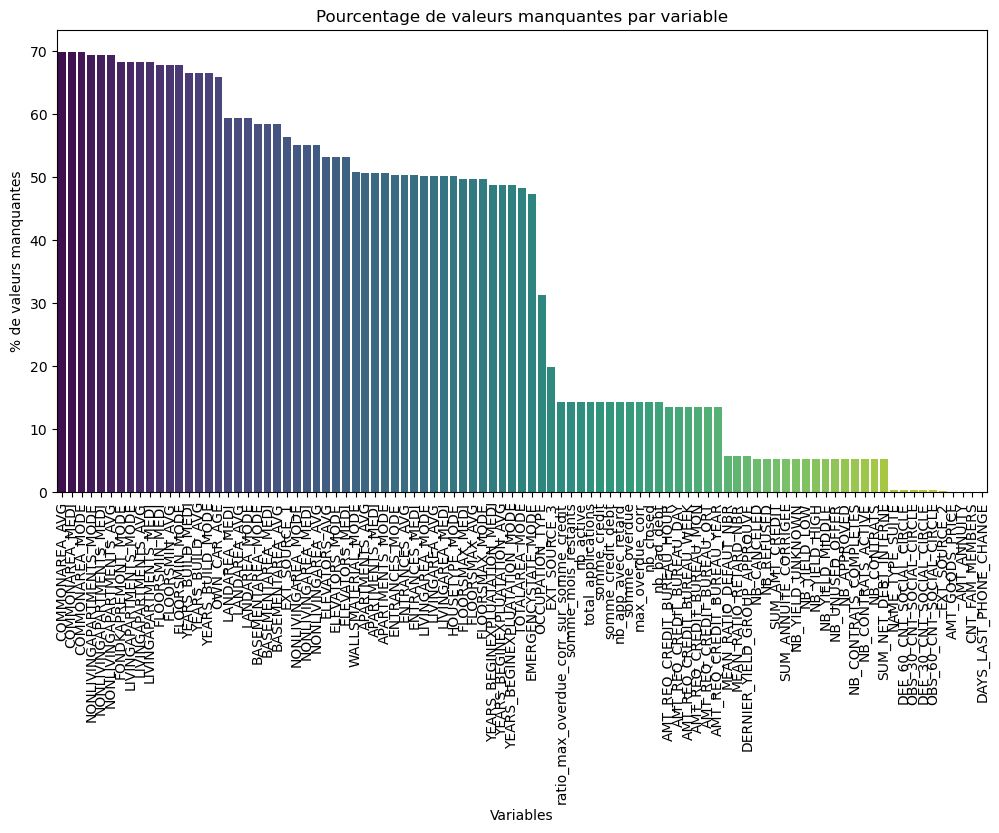

In [21]:
# Visualisation en barres
# ---------------------------
plt.figure(figsize=(12,6))
sns.barplot(x=missing_table.index, y=missing_table['% manquant'], palette='viridis')
plt.xticks(rotation=90)
plt.ylabel('% de valeurs manquantes')
plt.xlabel('Variables')
plt.title('Pourcentage de valeurs manquantes par variable')
plt.show()

In [22]:
# Calcul du seuil : au moins 50% de valeurs non manquantes
seuil = 0.5 * len(APPLICATION_TRAIN_MERGED)

# Drop des colonnes avec plus de 50% de NaN
APPLICATION_TRAIN_MERGED = APPLICATION_TRAIN_MERGED.dropna(thresh=seuil, axis=1)
print("Dimensions de la table APPLICATION_TRAIN_MERGED après le dernier traitement :", APPLICATION_TRAIN_MERGED.shape)

Dimensions de la table APPLICATION_TRAIN_MERGED après le dernier traitement : (307511, 113)


In [23]:
# Imputation pour les variables numériques avec la médiane
numeric_cols = APPLICATION_TRAIN_MERGED.select_dtypes(include=np.number).columns

for col in numeric_cols:
    median_value = APPLICATION_TRAIN_MERGED[col].median()
    APPLICATION_TRAIN_MERGED[col] = APPLICATION_TRAIN_MERGED[col].fillna(median_value)

# Imputation pour les variables catégorielles avec une nouvelle catégorie
categorical_cols = APPLICATION_TRAIN_MERGED.select_dtypes(include='object').columns

for col in categorical_cols:
    APPLICATION_TRAIN_MERGED[col] = APPLICATION_TRAIN_MERGED[col].fillna('Unknown')

In [24]:
#Suppression des colonnes qui n'ont pas d'explication métier :
COLONNES_A_SUPPRIMER = [
    'FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21'
]
APPLICATION_TRAIN_MERGED = APPLICATION_TRAIN_MERGED.drop(columns=COLONNES_A_SUPPRIMER, errors="ignore")
print("Dimensions de la table APPLICATION_TRAIN_MERGED après le dernier traitement :", APPLICATION_TRAIN_MERGED.shape)

Dimensions de la table APPLICATION_TRAIN_MERGED après le dernier traitement : (307511, 93)


In [25]:
#Suppression des variables numériques à faible variance : 
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

# Séparer X / y
y = APPLICATION_TRAIN_MERGED["TARGET"]
X = APPLICATION_TRAIN_MERGED.drop(columns=["TARGET"])

# Ne garder que les colonnes numériques
num_cols = X.select_dtypes(include=[np.number]).columns
X_num = X[num_cols]

# Imputation des NaN (obligatoire pour VarianceThreshold)
X_num_imp = SimpleImputer(strategy="median").fit_transform(X_num)

# Supprimer variables quasi-constantes
vt = VarianceThreshold(threshold=0.01)
mask = vt.fit(X_num_imp).get_support()
kept_num_cols = num_cols[mask]

# Reconstruire la table avec colonnes retenues
APPLICATION_TRAIN_MERGED = pd.concat(
    [y, X[kept_num_cols], X.drop(columns=num_cols)], axis=1
)
APPLICATION_TRAIN_MERGED_COPY=APPLICATION_TRAIN_MERGED
print("Dimensions de la table APPLICATION_TRAIN_MERGED après le dernier traitement :", APPLICATION_TRAIN_MERGED.shape)

Dimensions de la table APPLICATION_TRAIN_MERGED après le dernier traitement : (307511, 83)


In [26]:
# Colonnes à convertir
cols_days = [
    "DAYS_BIRTH",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "DAYS_LAST_PHONE_CHANGE",
    "DAYS_EMPLOYED"
]

# Conversion en années positives et arrondi à l'entier
APPLICATION_TRAIN_MERGED[cols_days] = (
    APPLICATION_TRAIN_MERGED[cols_days]
    .astype(float)
    .apply(lambda x: (-x / 365).round().astype(int))
)

print(APPLICATION_TRAIN_MERGED[cols_days].head())

   DAYS_BIRTH  DAYS_REGISTRATION  DAYS_ID_PUBLISH  DAYS_LAST_PHONE_CHANGE  \
0          26                 10                6                       3   
1          46                  3                1                       2   
2          52                 12                7                       2   
3          52                 27                7                       2   
4          55                 12                9                       3   

   DAYS_EMPLOYED  
0              2  
1              3  
2              1  
3              8  
4              8  


##### **2. Traitement des variables catégorielles**

In [27]:
# 1) Garder une version "propre" comme référence
APPLICATION_TRAIN_MERGED_BASE = APPLICATION_TRAIN_MERGED.copy()
print("Table de base :", APPLICATION_TRAIN_MERGED_BASE.shape)

# 2) Séparer cible et features
y = APPLICATION_TRAIN_MERGED_BASE["TARGET"]
X = APPLICATION_TRAIN_MERGED_BASE.drop(columns=["TARGET"])

# 3) Identifier les colonnes catégorielles
cat_cols = X.select_dtypes(include=["object", "category"]).columns
print(f"Nombre de colonnes catégorielles détectées : {len(cat_cols)}")
print("Exemple :", list(cat_cols[:10]))

Table de base : (307511, 83)
Nombre de colonnes catégorielles détectées : 14
Exemple : ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


In [ ]:
# One-Hot Encoding
X_ohe = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Recomposer dataset final
APPLICATION_TRAIN_MERGED_OHE = pd.concat([y, X_ohe], axis=1)

print("APPLICATION_TRAIN_MERGED_OHE :", APPLICATION_TRAIN_MERGED_OHE.shape)

In [29]:
X_label = X.copy()

# Encodage ordinal (chaque modalité -> entier)
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
if len(cat_cols) > 0:
    X_label[cat_cols] = oe.fit_transform(X_label[cat_cols])

APPLICATION_TRAIN_MERGED_LABEL = pd.concat([y, X_label], axis=1)

print("APPLICATION_TRAIN_MERGED_LABEL :", APPLICATION_TRAIN_MERGED_LABEL.shape)

APPLICATION_TRAIN_MERGED_LABEL : (307511, 83)


##### **3. Normalisation / Standardisation**

In [41]:
# ============================
# B) Dataset LABEL → Modèles arbres (pas de scaling)
# ============================

# Séparer cible / features
y_label = APPLICATION_TRAIN_MERGED_LABEL["TARGET"]
X_label = APPLICATION_TRAIN_MERGED_LABEL.drop(columns=["TARGET"])

# Split train/test (stratifié)
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
    X_label, y_label, test_size=0.30, stratify=y_label, random_state=42
)

print("LABEL → X_train:", X_train_label.shape, "| X_test:", X_test_label.shape)

LABEL → X_train: (215257, 82) | X_test: (92254, 82)


### >>>**Modèle de régression logistique**<<<

### >>>**Modèle de Machine Learning**<<<

In [31]:
#Préparer le poids de classe (déséquilibre)
neg, pos = np.bincount(y_train_label.astype(int))
scale_pos_weight = neg / pos
print(f"Répartition train → 0:{neg} | 1:{pos} | scale_pos_weight={scale_pos_weight:.2f}")

Répartition train → 0:197880 | 1:17377 | scale_pos_weight=11.39


In [ ]:
#Random Forest (baseline, gère le déséquilibre via class_weight)
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train_label, y_train_label)

proba_rf = rf.predict_proba(X_test_label)[:, 1]
pred_rf  = (proba_rf >= 0.50).astype(int)

print("RF AUC ROC :", roc_auc_score(y_test_label, proba_rf))
print("RF PR AUC  :", average_precision_score(y_test_label, proba_rf))
print("\nRF — rapport (seuil 0.5):\n", classification_report(y_test_label, pred_rf))
print("RF — matrice de confusion:\n", confusion_matrix(y_test_label, pred_rf))


In [33]:
#Gradient Boosting
# Poids pour compenser le déséquilibre (classe 1 minoritaire)
sample_w = compute_sample_weight(class_weight="balanced", y=y_train_label)

gb = GradientBoostingClassifier(
    loss="log_loss",
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    # early stopping interne (pas de split manuel)
    validation_fraction=0.2,
    n_iter_no_change=50,
    tol=1e-4
)

gb.fit(X_train_label, y_train_label, sample_weight=sample_w)

proba_gb = gb.predict_proba(X_test_label)[:, 1]
pred_gb  = (proba_gb >= 0.50).astype(int)

print("GB AUC ROC :", roc_auc_score(y_test_label, proba_gb))
print("GB PR AUC  :", average_precision_score(y_test_label, proba_gb))
print("\nGB — rapport (0.5):\n", classification_report(y_test_label, pred_gb))
print("GB — matrice de confusion:\n", confusion_matrix(y_test_label, pred_gb))

GB AUC ROC : 0.749102122395075
GB PR AUC  : 0.2334050794235314

GB — rapport (0.5):
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     84806
           1       0.16      0.68      0.26      7448

    accuracy                           0.69     92254
   macro avg       0.56      0.68      0.53     92254
weighted avg       0.90      0.69      0.76     92254

GB — matrice de confusion:
 [[58376 26430]
 [ 2396  5052]]


In [34]:
#LightGBM (scale_pos_weight + early stopping)
# split de validation pour early stopping
X_tr, X_va, y_tr, y_va = train_test_split(
    X_train_label, y_train_label, test_size=0.2, stratify=y_train_label, random_state=42
)

lgbm = lgb.LGBMClassifier(
    n_estimators=4000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# utiliser les callbacks pour l'early stopping (compatible avec les anciennes versions)
lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_va, y_va)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(200),     # patience = 200 itérations
        lgb.log_evaluation(0)        # 0 = pas d'affichage
    ]
)

# utiliser la meilleure itération trouvée
best_it = lgbm.best_iteration_
proba_lgb = lgbm.predict_proba(X_test_label, num_iteration=best_it)[:, 1]
pred_lgb  = (proba_lgb >= 0.50).astype(int)

print("LightGBM AUC ROC :", roc_auc_score(y_test_label, proba_lgb))
print("LightGBM PR AUC  :", average_precision_score(y_test_label, proba_lgb))
print("\nLightGBM — rapport (0.5):\n", classification_report(y_test_label, pred_lgb))
print("LightGBM — matrice de confusion:\n", confusion_matrix(y_test_label, pred_lgb))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13902, number of negative: 158303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6468
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 82
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432478
[LightGBM] [Info] Start training from score -2.432478
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.72705	training's binary_logloss: 0.276913	valid_1's auc: 0.704972	valid_1's binary_logloss: 0.277331
LightGBM AUC ROC : 0.7125135621028071
LightGBM PR AUC  : 0.1

C:\Users\mrkha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mrkha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mrkha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
#XGBoost (scale_pos_weight + early stopping)
X_tr_xgb, X_va_xgb, y_tr_xgb, y_va_xgb = train_test_split(
    X_train_label, y_train_label, test_size=0.2, stratify=y_train_label, random_state=42
)

xgb = XGBClassifier(
    n_estimators=3000,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight
)
xgb.fit(X_tr_xgb, y_tr_xgb, eval_set=[(X_va_xgb, y_va_xgb)], verbose=False)

proba_xgb = xgb.predict_proba(X_test_label)[:, 1]
pred_xgb  = (proba_xgb >= 0.50).astype(int)

print("XGB AUC ROC :", roc_auc_score(y_test_label, proba_xgb))
print("XGB PR AUC  :", average_precision_score(y_test_label, proba_xgb))
print("\nXGB — rapport (0.5):\n", classification_report(y_test_label, pred_xgb))
print("XGB — matrice de confusion:\n", confusion_matrix(y_test_label, pred_xgb))


XGB AUC ROC : 0.7506785136040448
XGB PR AUC  : 0.23970944838927447

XGB — rapport (0.5):
               precision    recall  f1-score   support

           0       0.95      0.87      0.91     84806
           1       0.23      0.44      0.30      7448

    accuracy                           0.84     92254
   macro avg       0.59      0.65      0.61     92254
weighted avg       0.89      0.84      0.86     92254

XGB — matrice de confusion:
 [[74041 10765]
 [ 4204  3244]]


In [36]:
# CatBoost (class_weights + early stopping)
X_tr_cb, X_va_cb, y_tr_cb, y_va_cb = train_test_split(
    X_train_label, y_train_label, test_size=0.2, stratify=y_train_label, random_state=42
)

# CatBoost accepte des poids par classe : [poids_classe_0, poids_classe_1]
class_weights = [1.0, float(scale_pos_weight)]

cb = CatBoostClassifier(
    iterations=4000,
    learning_rate=0.03,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_state=42,
    class_weights=class_weights,
    verbose=False
)

train_pool = Pool(X_tr_cb, y_tr_cb)
valid_pool = Pool(X_va_cb, y_va_cb)

cb.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, verbose=False)

proba_cb = cb.predict_proba(X_test_label)[:, 1]
pred_cb  = (proba_cb >= 0.50).astype(int)

print("CAT AUC ROC :", roc_auc_score(y_test_label, proba_cb))
print("CAT PR AUC  :", average_precision_score(y_test_label, proba_cb))
print("\nCAT — rapport (0.5):\n", classification_report(y_test_label, pred_cb))
print("CAT — matrice de confusion:\n", confusion_matrix(y_test_label, pred_cb))


CAT AUC ROC : 0.7694678465994276
CAT PR AUC  : 0.2561076294569646

CAT — rapport (0.5):
               precision    recall  f1-score   support

           0       0.96      0.72      0.83     84806
           1       0.18      0.68      0.28      7448

    accuracy                           0.72     92254
   macro avg       0.57      0.70      0.55     92254
weighted avg       0.90      0.72      0.78     92254

CAT — matrice de confusion:
 [[61419 23387]
 [ 2390  5058]]


In [37]:
#Régression logistique (baseline)

# Modèle (pondération pour le déséquilibre)
logit = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=2000,
    class_weight="balanced"
)

# Entraînement
logit.fit(X_train_ohe_scaled, y_train_ohe)

# Prédictions proba + étiquette à seuil 0.5
proba_logit = logit.predict_proba(X_test_ohe_scaled)[:, 1]
pred_logit  = (proba_logit >= 0.50).astype(int)

# Métriques
print("Logit AUC ROC :", roc_auc_score(y_test_ohe, proba_logit))
print("Logit PR AUC  :", average_precision_score(y_test_ohe, proba_logit))
print("\nLogit — rapport (0.5):\n", classification_report(y_test_ohe, pred_logit))
print("Logit — matrice de confusion:\n", confusion_matrix(y_test_ohe, pred_logit))


Logit AUC ROC : 0.7591644053821152
Logit PR AUC  : 0.23868469989610677

Logit — rapport (0.5):
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     84806
           1       0.17      0.69      0.27      7448

    accuracy                           0.70     92254
   macro avg       0.56      0.69      0.54     92254
weighted avg       0.90      0.70      0.77     92254

Logit — matrice de confusion:
 [[59164 25642]
 [ 2322  5126]]


### >>>**Modèle de régression logistique**<<<

In [48]:
# =========================
# 0) Paramètres
# =========================
ID_COL = "SK_ID_CURR"      # retire si présent
CORR_THR = 0.7           # corrélation (abs) au-delà de laquelle on supprime une variable
VIF_THR  = 8.0              # seuil VIF (8 ou 10 usuels)

# =========================
# 1) Préparer X / y
# =========================
feature_cols = list(X_train_label.columns)
if ID_COL in feature_cols:
    feature_cols.remove(ID_COL)

def prep_X(df, cols):
    X = df[cols].copy()
    # types numériques + NaN/Inf
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.fillna(0.0).astype(float)
    return X

Xtr_raw = prep_X(X_train_label, feature_cols)
Xte_raw = prep_X(X_test_label,  feature_cols)
y_tr = y_train_label.astype(int)
y_te = y_test_label.astype(int)

# Retirer variables constantes/quasi constantes
zero_var = [c for c in Xtr_raw.columns if Xtr_raw[c].nunique(dropna=True) <= 1]
if zero_var:
    print(f"[Info] Constantes retirées: {len(zero_var)}")
    Xtr_raw = Xtr_raw.drop(columns=zero_var)
    Xte_raw = Xte_raw.drop(columns=zero_var, errors="ignore")

# =========================
# 2) Casser corrélations quasi parfaites (|ρ| ≥ CORR_THR)
# =========================
corr = Xtr_raw.corr(method="spearman").abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_corr = [c for c in upper.columns if any(upper[c] >= CORR_THR)]
if to_drop_corr:
    print(f"[Info] Corrélations ~1 retirées: {len(to_drop_corr)}")
    Xtr_raw = Xtr_raw.drop(columns=to_drop_corr)
    Xte_raw = Xte_raw.drop(columns=to_drop_corr, errors="ignore")

# =========================
# 3) Filtre VIF “safe”
# =========================
def vif_filter_safe(X: pd.DataFrame, thresh=8.0, max_iter=200):
    cols = list(X.columns)
    dropped = []
    for _ in range(max_iter):
        Xc = sm.add_constant(X[cols], has_constant="add")
        vifs = []
        names = list(Xc.columns)
        for i, name in enumerate(names):
            if name == "const":
                vifs.append(np.nan)
                continue
            try:
                v = variance_inflation_factor(Xc.values, i)
            except Exception:
                v = np.inf
            if not np.isfinite(v):
                v = np.inf
            vifs.append(v)
        s = pd.Series(vifs, index=names).drop("const", errors="ignore")
        worst, max_v = s.idxmax(), float(s.max())
        if (not np.isfinite(max_v)) or (max_v > thresh):
            cols.remove(worst)
            dropped.append((worst, max_v))
        else:
            break
    log = pd.DataFrame(dropped, columns=["dropped_feature", "VIF"])
    # VIF final des colonnes conservées (pour information)
    Xc_final = sm.add_constant(X[cols], has_constant="add")
    vifs_final = pd.Series(
        [variance_inflation_factor(Xc_final.values, i) if n!="const" else np.nan
         for i, n in enumerate(Xc_final.columns)],
        index=Xc_final.columns
    ).drop("const", errors="ignore")
    return cols, vifs_final.sort_values(ascending=False), log

keep_cols, vif_last, dropped_log = vif_filter_safe(Xtr_raw, thresh=VIF_THR)
print(f"VIF — variables conservées : {len(keep_cols)} / {Xtr_raw.shape[1]}")
if not dropped_log.empty:
    print("VIF — variables retirées (ordre):")
    print(dropped_log.head(25))

# X final pour le modèle
Xtr = sm.add_constant(Xtr_raw[keep_cols], has_constant="add")
Xte = sm.add_constant(Xte_raw[keep_cols], has_constant="add")

# =========================
# 4) Poids de classe (déséquilibre)
# =========================
w = compute_sample_weight(class_weight="balanced", y=y_tr)

# =========================
# 5) Régression logistique (MLE → fallback Ridge si instable)
# =========================
try:
    logit = sm.Logit(y_tr, Xtr)
    res = logit.fit(maxiter=300, disp=0)
    penalized = False
    print("\n[Info] Fit MLE réussi (p-values disponibles).")
except Exception as e:
    print("[Info] MLE instable → GLM pénalisée (Ridge). Raison :", e)
    glm = sm.GLM(y_tr, Xtr, family=sm.families.Binomial(), freq_weights=w)
    res = glm.fit_regularized(alpha=1.0, L1_wt=0.0, maxiter=500)  # L2
    penalized = True

# Résumé/coefficients
if not penalized:
    print(res.summary())
else:
    coefs = pd.Series(res.params, index=Xtr.columns).sort_values()
    print("\n[GLM Ridge] — Top effets négatifs:\n", coefs.head(10))
    print("\n[GLM Ridge] — Top effets positifs:\n", coefs.tail(10))

# =========================
# 6) Évaluation
# =========================
# Probabilités (clip marge si reconstruction manuelle)
if hasattr(res, "predict"):
    proba = res.predict(Xte)
else:
    lin = Xte.to_numpy() @ res.params
    lin = np.clip(lin, -35, 35)
    proba = 1.0 / (1.0 + np.exp(-lin))

print("\nAUC ROC :", roc_auc_score(y_te, proba))
print("PR  AUC :", average_precision_score(y_te, proba))

# Seuil 0.5
pred_05 = (proba >= 0.50).astype(int)
print("\nRapport (0.5):\n", classification_report(y_te, pred_05))
print("Matrice de confusion (0.5):\n", confusion_matrix(y_te, pred_05))

# Seuil F1 (diagnostic)
p, r, t = precision_recall_curve(y_te, proba)
f1 = (2*p*r)/(p+r+1e-12)
i = int(np.nanargmax(f1))
thr_f1 = t[i-1] if i>0 else 0.5
pred_f1 = (proba >= thr_f1).astype(int)
print(f"\nSeuil optimisé (F1) ≈ {thr_f1:.3f}")
print("Rapport (F1):\n", classification_report(y_te, pred_f1))
print("Matrice de confusion (F1):\n", confusion_matrix(y_te, pred_f1))

# (Option) Table récap rapide
def perf_table(y_true, proba, thr_list, name="Logit LABEL (anti-colinéarité)"):
    auc_roc = roc_auc_score(y_true, proba)
    pr_auc  = average_precision_score(y_true, proba)
    fpr, tpr, _ = roc_curve(y_true, proba)
    ks = float(np.max(tpr - fpr))
    rows = []
    for thr in thr_list:
        pred = (proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        rows.append({
            "Modèle": name, "Seuil": round(float(thr),3),
            "AUC ROC": auc_roc, "PR AUC": pr_auc, "KS": ks,
            "Précision(1)": precision_score(y_true, pred, zero_division=0),
            "Rappel(1)": recall_score(y_true, pred),
            "F1(1)": f1_score(y_true, pred),
            "Accuracy": accuracy_score(y_true, pred),
            "TN": tn, "FP": fp, "FN": fn, "TP": tp
        })
    return pd.DataFrame(rows)

print("\n=== Récap ===")
print(perf_table(y_te, proba, [0.50, thr_f1]))


[Info] Corrélations ~1 retirées: 22
VIF — variables conservées : 57 / 59
VIF — variables retirées (ordre):
  dropped_feature          VIF
0  FLAG_EMP_PHONE  1986.748880
1     NB_CONTRATS    33.419837

[Info] Fit MLE réussi (p-values disponibles).
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               215257
Model:                          Logit   Df Residuals:                   215199
Method:                           MLE   Df Model:                           57
Date:                Thu, 28 Aug 2025   Pseudo R-squ.:                  0.1097
Time:                        21:55:16   Log-Likelihood:                -53763.
converged:                       True   LL-Null:                       -60388.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------

=== Tableau comparatif (tous modèles) ===


,Modèle,Panel,AUC ROC,PR AUC,KS,Base rate,Seuil F1,Precision@0.5,Recall@0.5,F1@0.5,BalancedAcc@0.5,Precision@F1,Recall@F1,F1@F1
4,CatBoost,LABEL,0.769468,0.256108,0.405365,0.080734,0.664921,0.177817,0.679108,0.281838,0.701669,0.261157,0.407760,0.318394
3,XGBoost,LABEL,0.750679,0.239709,0.373771,0.080734,0.536851,0.231565,0.435553,0.302372,0.654308,0.247281,0.393797,0.303796
1,GradientBoosting,LABEL,0.749102,0.233405,0.370040,0.080734,0.614633,0.160473,0.678303,0.259543,0.683325,0.220101,0.455156,0.296718
0,RandomForest,LABEL,0.753760,0.229195,0.382940,0.080734,0.163412,0.543478,0.003357,0.006672,0.501554,0.227113,0.461332,0.304381
5,Logit (statsmodels),LABEL,0.748626,0.227029,0.368070,0.080734,0.147601,0.465863,0.015575,0.030142,0.507003,0.239377,0.404672,0.300813
2,LightGBM,LABEL,0.712514,0.183096,0.320255,0.080734,0.099885,0.000000,0.000000,0.000000,0.500000,0.206449,0.369629,0.264928
6,"Logit (sklearn, OHE)",OHE,0.759164,0.238685,0.388306,0.080734,0.670077,0.166602,0.688238,0.268265,0.692939,0.243314,0.421455,0.308516


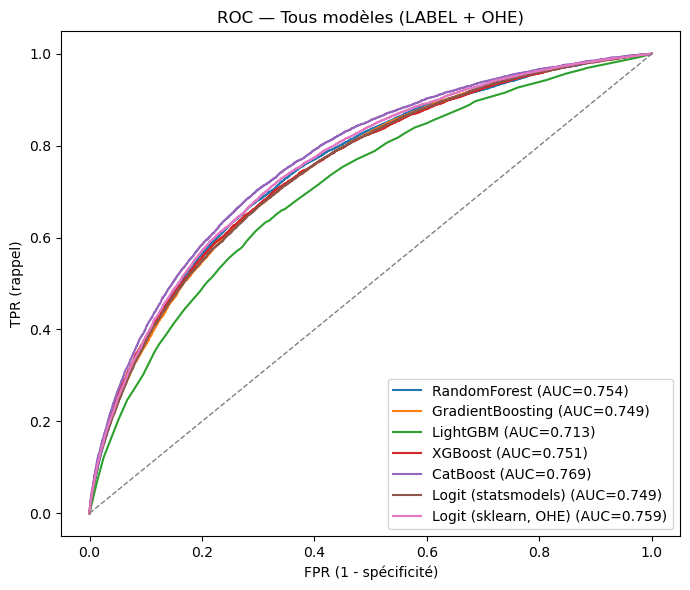

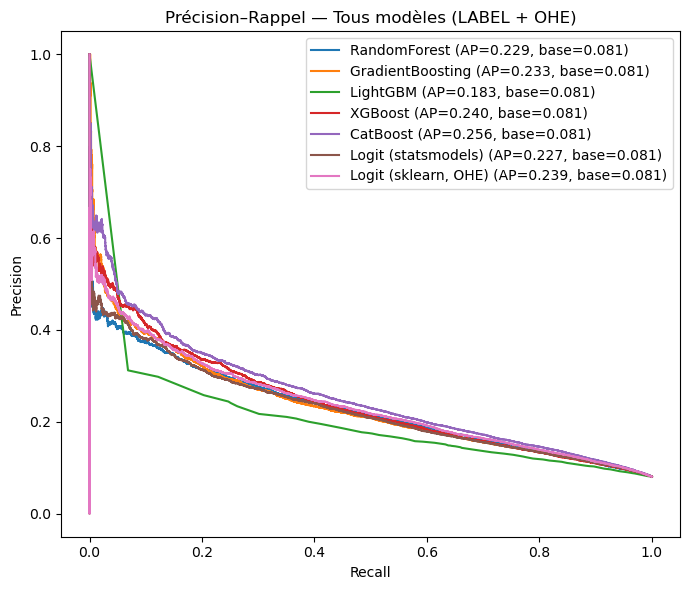

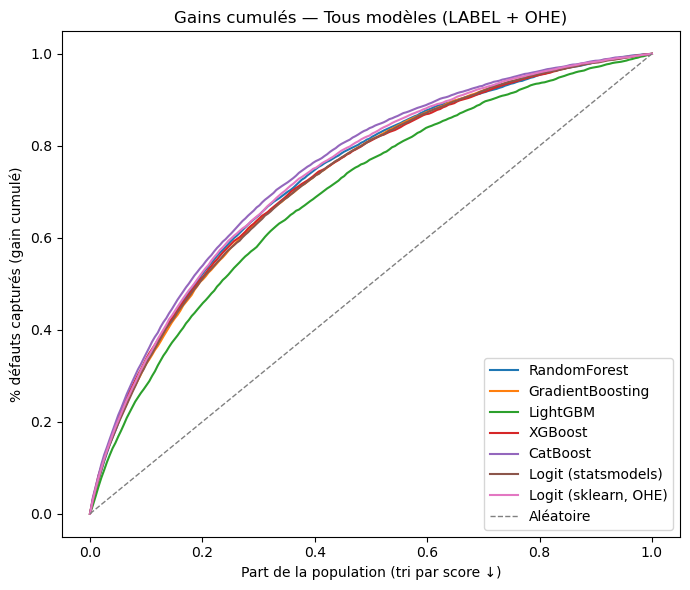

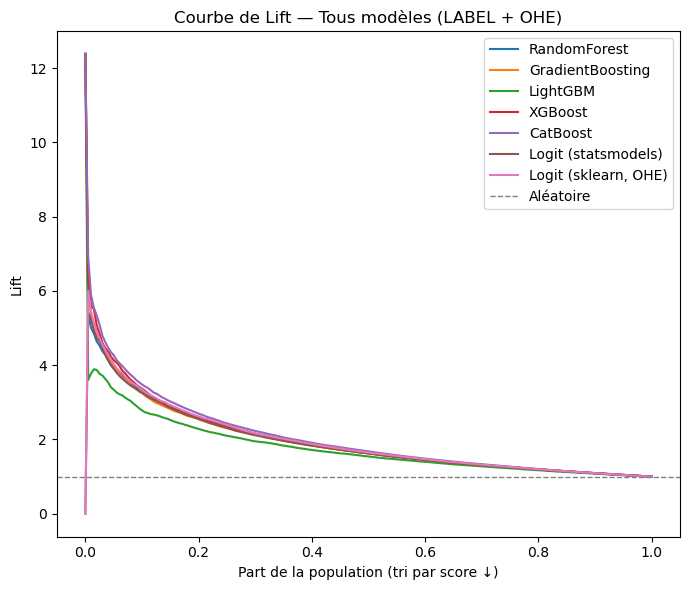

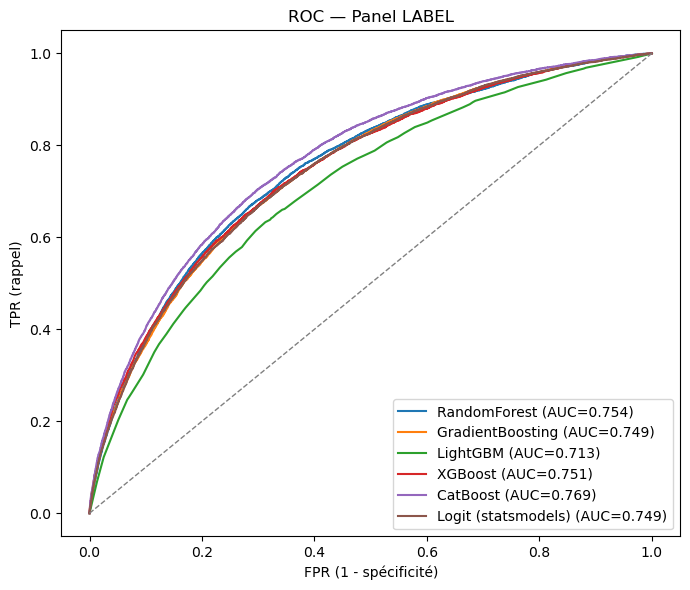

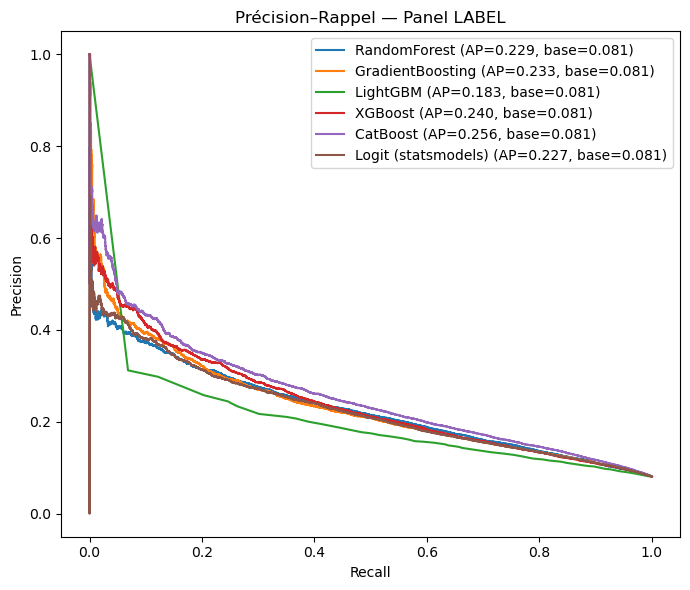

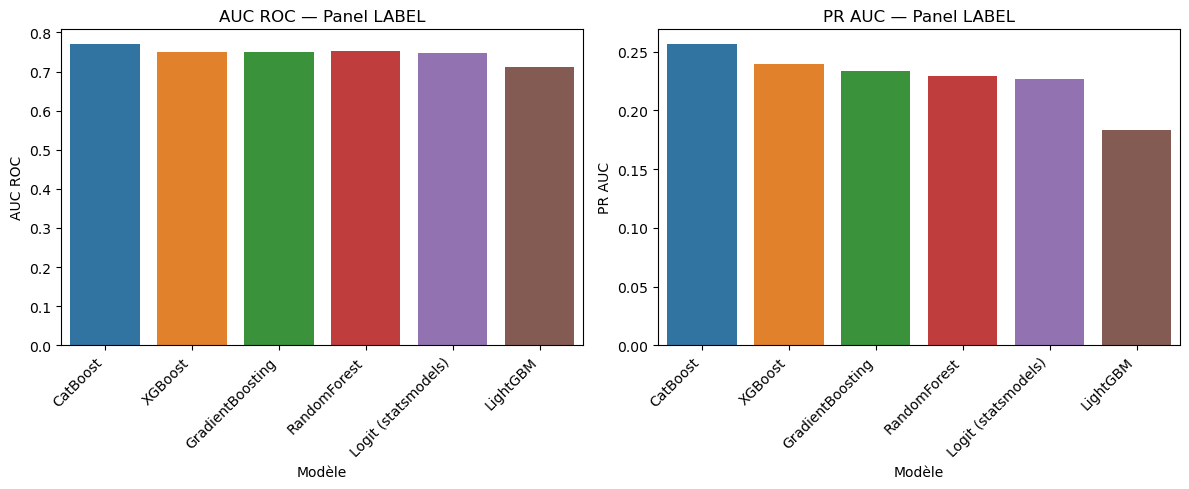

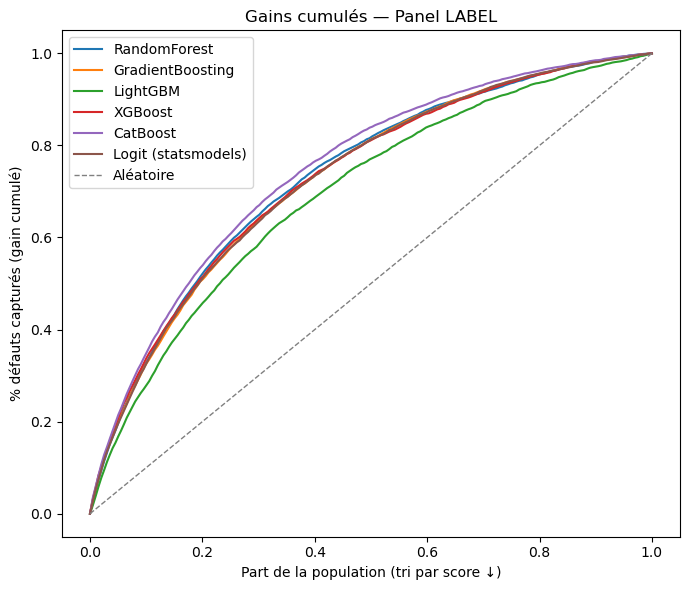

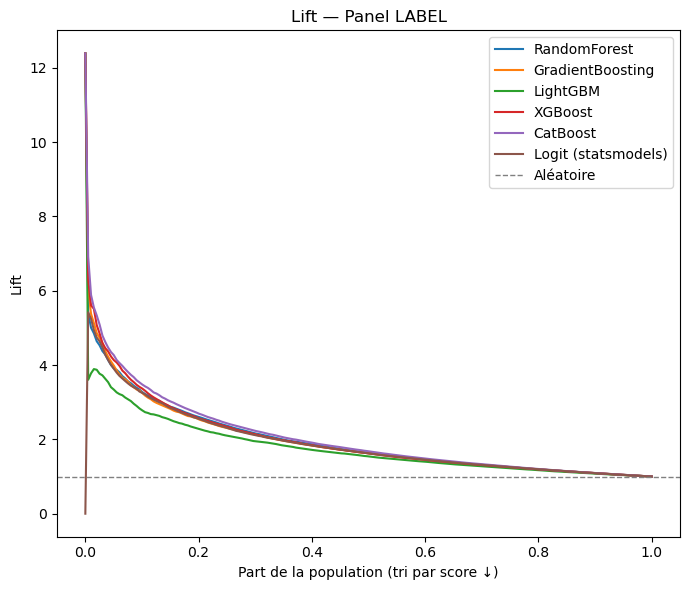

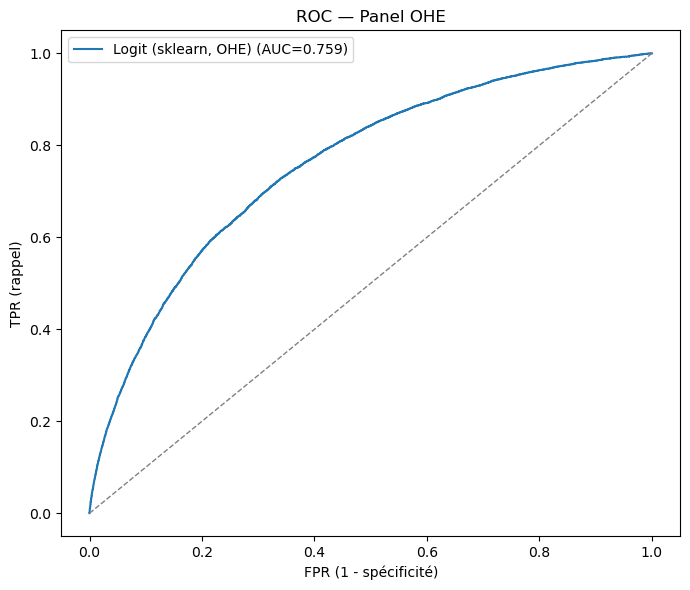

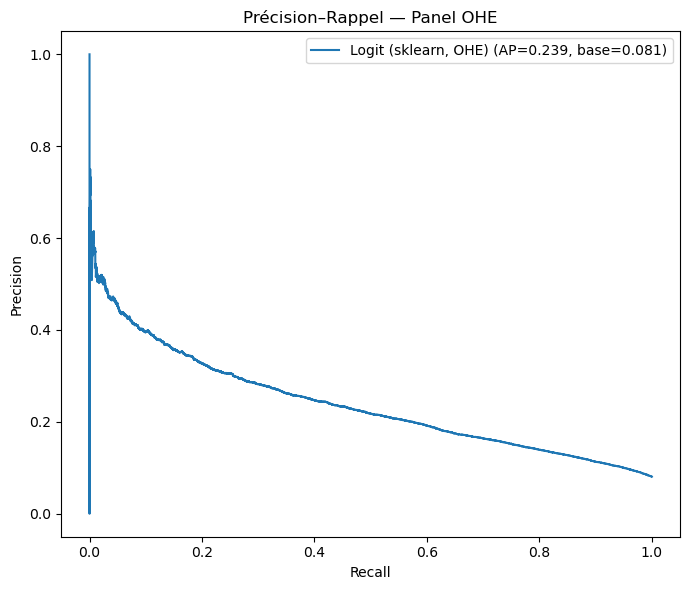

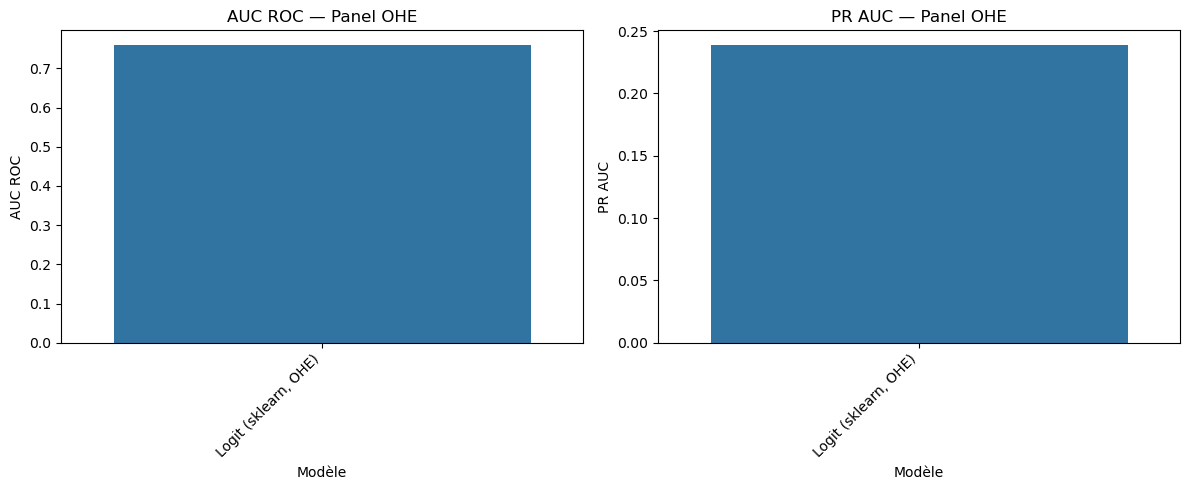

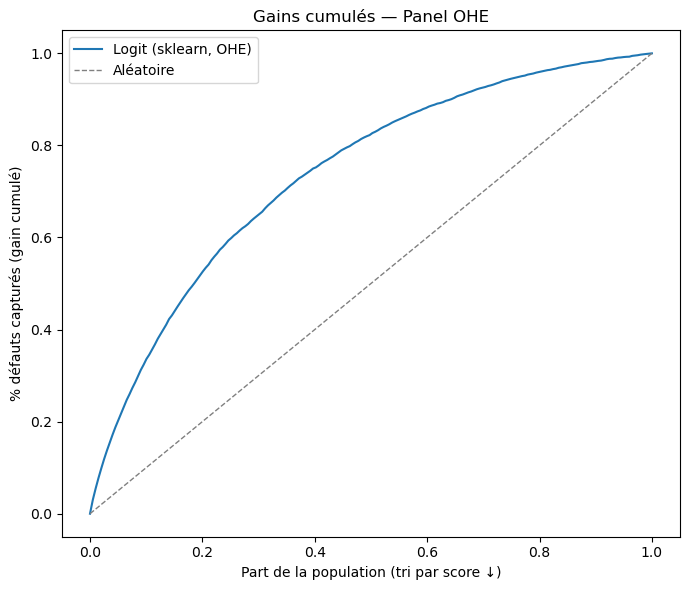

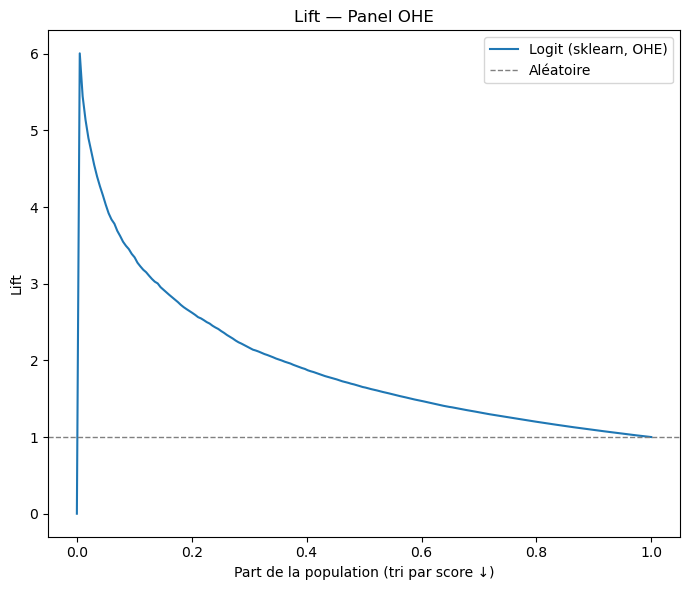

In [55]:
# =============================
# Comparatif visuel (7 modèles) + Courbes Lift
# =============================
# ---------- Utils ----------
def add_model(lst, name, proba, y_true, panel):
    lst.append({
        "name": name,
        "proba": np.asarray(proba),
        "y": np.asarray(y_true).astype(int),
        "panel": panel  # "LABEL" ou "OHE"
    })

def metrics_with_thresholds(y, proba, thr_fixed=0.50):
    auc = roc_auc_score(y, proba)
    ap  = average_precision_score(y, proba)
    base = float(np.mean(y))
    fpr, tpr, _ = roc_curve(y, proba); ks = float(np.max(tpr - fpr))

    p, r, t = precision_recall_curve(y, proba)
    f1_curve = (2*p*r)/(p+r+1e-12)
    i = int(np.nanargmax(f1_curve))
    thr_f1 = t[i-1] if i > 0 else thr_fixed

    def at_thr(th):
        pred = (proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        return dict(
            precision=precision_score(y, pred, zero_division=0),
            recall=recall_score(y, pred),
            f1=f1_score(y, pred),
            accuracy=accuracy_score(y, pred),
            specificity=tn/(tn+fp) if (tn+fp)>0 else np.nan,
            balanced_accuracy=(tn/(tn+fp)+recall_score(y, pred))/2 if (tn+fp)>0 else np.nan,
            TP=tp, FP=fp, TN=tn, FN=fn
        )

    return {"auc":auc, "ap":ap, "base":base, "ks":ks, "thr_f1":thr_f1,
            "at05":at_thr(thr_fixed), "atf1":at_thr(thr_f1)}

def build_perf_df(models):
    rows = []
    for m in models:
        met = metrics_with_thresholds(m["y"], m["proba"], thr_fixed=0.50)
        rows.append({
            "Modèle": m["name"], "Panel": m["panel"],
            "AUC ROC": met["auc"], "PR AUC": met["ap"], "KS": met["ks"], "Base rate": met["base"],
            "Seuil F1": met["thr_f1"],
            "Precision@0.5": met["at05"]["precision"], "Recall@0.5": met["at05"]["recall"],
            "F1@0.5": met["at05"]["f1"], "BalancedAcc@0.5": met["at05"]["balanced_accuracy"],
            "Precision@F1": met["atf1"]["precision"], "Recall@F1": met["atf1"]["recall"], "F1@F1": met["atf1"]["f1"]
        })
    return pd.DataFrame(rows).sort_values(["Panel","PR AUC","AUC ROC"], ascending=[True,False,False])

def plot_roc(models, title):
    plt.figure(figsize=(7,6))
    for m in models:
        fpr, tpr, _ = roc_curve(m["y"], m["proba"])
        auc = roc_auc_score(m["y"], m["proba"])
        plt.plot(fpr, tpr, label=f'{m["name"]} (AUC={auc:.3f})')
    plt.plot([0,1],[0,1],'--',color='gray',lw=1)
    plt.xlabel("FPR (1 - spécificité)"); plt.ylabel("TPR (rappel)")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def plot_pr(models, title):
    plt.figure(figsize=(7,6))
    for m in models:
        prec, rec, _ = precision_recall_curve(m["y"], m["proba"])
        ap = average_precision_score(m["y"], m["proba"])
        base = m["y"].mean()
        plt.plot(rec, prec, label=f'{m["name"]} (AP={ap:.3f}, base={base:.3f})')
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def cumulative_gain_points(y, proba, n_points=200):
    order = np.argsort(-proba); y_sorted = y[order]
    cum_pos = np.cumsum(y_sorted); total_pos = cum_pos[-1] if cum_pos.size else 0
    xs = np.linspace(1/len(y), 1.0, len(y))
    gains = cum_pos / total_pos if total_pos>0 else np.zeros_like(cum_pos, float)
    idx = np.linspace(0, len(y)-1, min(n_points, len(y))).astype(int)
    return xs[idx], gains[idx]

def plot_gains(models, title, top_k=None):
    # option top_k pour limiter le nombre de courbes
    sel = models
    if top_k is not None and top_k < len(models):
        scored = sorted([(average_precision_score(m["y"], m["proba"]), m) for m in models], reverse=True)
        sel = [m for _, m in scored[:top_k]]

    plt.figure(figsize=(7,6))
    for m in sel:
        xs, ys = cumulative_gain_points(m["y"], m["proba"])
        plt.plot(xs, ys, label=m["name"])
    plt.plot([0,1],[0,1],'--',color='gray',lw=1,label="Aléatoire")
    plt.xlabel("Part de la population (tri par score ↓)")
    plt.ylabel("% défauts capturés (gain cumulé)")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def plot_lift(models, title, top_k=None):
    sel = models
    if top_k is not None and top_k < len(models):
        scored = sorted([(average_precision_score(m["y"], m["proba"]), m) for m in models], reverse=True)
        sel = [m for _, m in scored[:top_k]]

    plt.figure(figsize=(7,6))
    for m in sel:
        xs, gains = cumulative_gain_points(m["y"], m["proba"])
        xs = np.clip(xs, 1e-6, None)               # évite division par zéro
        lift = gains / xs                           # Lift = Gain / baseline
        plt.plot(xs, lift, label=m["name"])
    plt.axhline(1.0, ls="--", color="gray", lw=1, label="Aléatoire")
    plt.xlabel("Part de la population (tri par score ↓)")
    plt.ylabel("Lift")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def plot_bars(perf_df, title_suffix):
    df = perf_df.copy()
    order = df.sort_values("PR AUC", ascending=False)["Modèle"]
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sns.barplot(data=df, x="Modèle", y="AUC ROC", order=order, ax=ax[0])
    ax[0].set_title(f"AUC ROC — {title_suffix}"); ax[0].set_xticklabels(order, rotation=45, ha="right")
    sns.barplot(data=df, x="Modèle", y="PR AUC", order=order, ax=ax[1])
    ax[1].set_title(f"PR AUC — {title_suffix}"); ax[1].set_xticklabels(order, rotation=45, ha="right")
    plt.tight_layout(); plt.show()

# ---------- Rassembler les 7 modèles ----------
models = []
# Panel LABEL
add_model(models, "RandomForest",         proba_rf,   y_test_label, "LABEL")
add_model(models, "GradientBoosting",     proba_gb,   y_test_label, "LABEL")
add_model(models, "LightGBM",             proba_lgb,  y_test_label, "LABEL")
add_model(models, "XGBoost",              proba_xgb,  y_test_label, "LABEL")
add_model(models, "CatBoost",             proba_cb,   y_test_label, "LABEL")
add_model(models, "Logit (statsmodels)",  proba,      y_te,         "LABEL")   # proba du modèle SM (LABEL)

# Panel OHE — on veut la voir dans TOUS les visuels aussi
add_model(models, "Logit (sklearn, OHE)", proba_logit, y_test_ohe,  "OHE")

# ---------- Table synthétique ----------
perf_all = build_perf_df(models)
print("=== Tableau comparatif (tous modèles) ===")
display(perf_all)

# ---------- VISU 1 : TOUS LES MODÈLES ENSEMBLE (même si les panels diffèrent)
# (attention : la baseline PR peut différer entre LABEL et OHE)
plot_roc(models, "ROC — Tous modèles (LABEL + OHE)")
plot_pr(models,  "Précision–Rappel — Tous modèles (LABEL + OHE)")
plot_gains(models, "Gains cumulés — Tous modèles (LABEL + OHE)")
plot_lift(models,  "Courbe de Lift — Tous modèles (LABEL + OHE)")

# ---------- VISU 2 : PAR PANEL (si tu veux séparer les contextes)
panel_label = [m for m in models if m["panel"]=="LABEL"]
panel_ohe   = [m for m in models if m["panel"]=="OHE"]

if panel_label:
    perf_label = perf_all[perf_all["Panel"]=="LABEL"]
    plot_roc(panel_label, "ROC — Panel LABEL")
    plot_pr(panel_label,  "Précision–Rappel — Panel LABEL")
    plot_bars(perf_label, "Panel LABEL")
    plot_gains(panel_label, "Gains cumulés — Panel LABEL")
    plot_lift(panel_label,  "Lift — Panel LABEL")

if panel_ohe:
    perf_ohe = perf_all[perf_all["Panel"]=="OHE"]
    plot_roc(panel_ohe, "ROC — Panel OHE")
    plot_pr(panel_ohe,  "Précision–Rappel — Panel OHE")
    plot_bars(perf_ohe, "Panel OHE")
    plot_gains(panel_ohe, "Gains cumulés — Panel OHE")
    plot_lift(panel_ohe,  "Lift — Panel OHE")
